In [ ]:
#@title
import numpy as np
import matplotlib.pyplot as plt
import math

##################################
#Polynomail Interpolation
##################################
## Newton's Method for Polynomial Interpolation
def getCoefficients(xData, yData):
  m = len(xData)
  a = yData.copy()

  for k in range(1, m):
    a[k:m] = (a[k:m] - a[k-1])/(xData[k:m] - xData[k-1])

  return a

def evaluatePolynomial(a, xData, x):
  deg = len(xData) - 1
  p = a[deg]

  for k in range(1, deg + 1):
    p = a[deg-k] + (x - xData[deg-k])*p

  return p

##################################
#DoolittleLUdecomp3solver()
##################################
def DoolittleLUdecomp3(c, d, e):
  n = len(d)
  for k in range(1, n):
    lam = c[k-1]/d[k-1]
    d[k] = d[k] - lam*e[k-1]
    c[k-1] = lam

  return c, d, e

def Doolittle3solver(lam, d, e, b):
  n = len(d)
  y = b
  for k in range(1, n):
    y[k] = b[k] - lam[k-1]*y[k-1]

  x = y
  x[n-1] = y[n-1]/d[n-1]
  for k in range(n-2, -1, -1):
    x[k] = (y[k] - e[k]*x[k+1])/d[k]

  return x

def DoolittleLUdecomp3solver(c, d, e, b):
  lam, d, e = DoolittleLUdecomp3(c, d, e)
  x = Doolittle3solver(lam, d, e, b)

  return x

##################################
##Cubic Spline Interpolator
##################################
def curvatures(xData, yData):
  n = len(xData) - 1
  c = np.zeros(n)
  d = np.ones(n+1)
  e = np.zeros(n)
  k = np.zeros(n+1)

  c[0:(n-1)] = xData[0:(n-1)] - xData[1:n]
  d[1:n] = 2.0*(xData[0:(n-1)] - xData[2:(n+1)])
  e[1:n] = xData[1:n] - xData[2:(n+1)]
  k[1:n] = 6.0*((yData[0:(n-1)] - yData[1:n])/(xData[0:(n-1)] - xData[1:n])) - 6.0*((yData[1:n] - yData[2:(n+1)])/(xData[1:n] - xData[2:(n+1)]))

  #DoolittleLUdecomp3(c, d, e)
  DoolittleLUdecomp3solver(c, d, e, k)

  return k

def findSegment(xData, x):
    iLeft = 0
    iRight = len(xData) - 1

    while 1:
      if (iRight - iLeft) <= 1:
        return iLeft
      i = int((iLeft + iRight)/2)
      if x < xData[i]:
        iRight = i
      else:
        iLeft = i

def evalSpline(xData, yData, k, x):
  i = findSegment(xData, x)
  h = xData[i] - xData[i+1]
  y = ((x - xData[i+1])**3/h - (x - xData[i+1])*h)*k[i]/6.0 - ((x - xData[i])**3/h - (x - xData[i])*h)*k[i+1]/6.0 + (yData[i]*(x - xData[i+1]) - yData[i+1]*(x - xData[i]))/h
  y = ((x - xData[i+1])**3/h - (x - xData[i+1])*h)*k[i]/6.0 - ((x - xData[i])**3/h - (x - xData[i])*h)*k[i+1]/6.0 + (yData[i]*(x - xData[i+1]) - yData[i+1]*(x - xData[i]))/h


  return y

# Day 10: Interpolation with Cubic Splines

In the previous notebook, we highlighted that polynomial interpolation should be done with the fewest number of observed data points which is feasible. This is perhaps counterintuitive since we typically think of more data as "better" since it is additional information. The problem with polynomial interpolation is that additional data points increase the degree of the polynomial interpolant. This can result in polynomials that fluctuate wildly between observed data points.

If we have more than just a few observed data points to work with, a cubic spline is a great option for an interpolant. Cubic splines consist of two main components (i) *pins* (or *knots*) are the observed data points that the interpolant is required to pass through, and (ii) *elastic strips* correspond to "unloaded beams" connecting observed data points. For those with a background in engineering, you may remember that the deflection ($w$) of an unloaded beam between two connection points with constant flexural rigidity satisfies $\displaystyle{\frac{d^4w}{dx^4} = \frac{q\left(x\right)}{EI}}$, where $q\left(x\right)$ denotes the *load* at position $x$ along the beam. Since the beam is *unloaded*, we have $\displaystyle{\frac{d^4w}{dx^4} = 0}$, so the elastic strip is a cubic.

Cubic splines have some additional nice properties. At the observed data points, the slope and second derivative are continuous and the second derivative at the left-most and right-most observed data points is $0$.

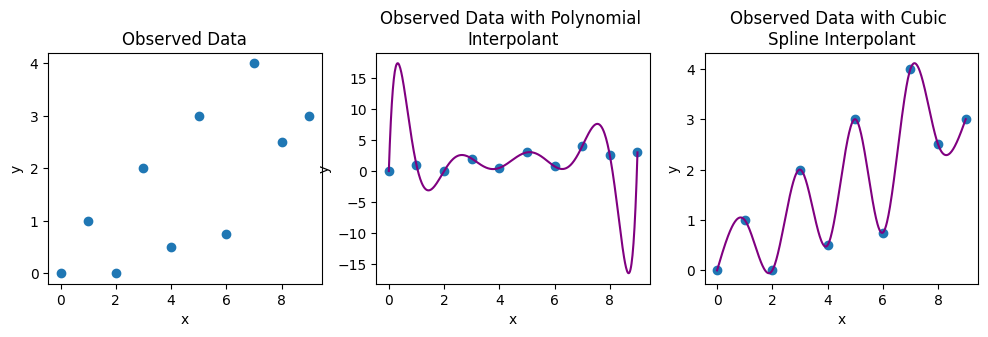

In [ ]:
#@title
x = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y = np.array([0, 1, 0, 2, 0.5, 3, 0.75, 4, 2.5, 3])

x_new = np.linspace(0, 9, 500)
y_new_poly = len(x_new)*[0.0]
y_new_spline = len(x_new)*[0.0]

coefs = getCoefficients(x, y)
y_new_poly = evaluatePolynomial(coefs, x, x_new)

k = curvatures(x, y)

for i in range(len(x_new)):
  y_new_spline[i] = evalSpline(x, y, k, x_new[i])

plt.figure(figsize = (12, 3))

plt.subplot(1, 3, 1)
plt.scatter(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Observed Data")

plt.subplot(1, 3, 2)
plt.plot(x_new, y_new_poly, color = "purple")
plt.scatter(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Observed Data with Polynomial \nInterpolant")

plt.subplot(1, 3, 3)
plt.plot(x_new, y_new_spline, color = "purple")
plt.scatter(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Observed Data with Cubic \nSpline Interpolant")

plt.show()

## Constructing A Cubic Spline Interpolant

Consider a set of $n+1$ observed data points $\left(x_0, y_0\right),~\left(x_1, y_1\right),~\cdots,~\left(x_n, y_n\right)$ with $x_0 < x_1 < \cdots < x_n$. A cubic spline interpolant will consist of $n$ cubic segments, $f_{i, i+1}\left(x\right)$ for $i = 0,~1,~\cdots,~n-1$. The full cubic spline interpolant is a piecewise cubic consisting of each of these cubic sections, having continuous first- and second-derivatives at each of the *knots* (observed data points).

Because we know that each segment is a cubic, and that the second derivative of the spline interpolant is continuous, we must have that the second derivative to the left and right of each knot point match. That is, for any $i$

$$f_{i-1,i}''\left(x_i\right) = f_{i, i+1}''\left(x_i\right) = k_i$$

We know that $k_0 = k_n = 0$, but all of the other $k_i$ are unknown and need to be solved for. We can use Lagrange's two-point interpolation as a starting point for computing the unknown coefficients of each $f_{i,i+1}\left(x\right)$. We can write

$$f_{i,i+1}''\left(x\right) = k_i\ell_i\left(x\right) + k_{i+1}\ell_{i+1}\left(x\right)$$

where $\ell_{i}\left(x\right) = \frac{x - x_{i+1}}{x_i - x_{i+1}}$ and $\ell_{i+1}\left(x\right) = \frac{x - x_i}{x_{i+1} - x_i}$, so

\begin{align*} f_{i,i+1}''\left(x\right) &= k_i\left(\frac{x - x_{i+1}}{x_i - x_{i+1}}\right) + k_{i+1}\left(\frac{x - x_i}{x_{i+1} - x_i}\right)\\
\implies f_{i,i+1}''\left(x\right) &= \frac{k_i\left(x - x_{i+1}\right) - k_{i+1}\left(x - x_i\right)}{x_i - x_{i+1}}\\
\implies \int{f_{i,i+1}''\left(x\right)dx} &= \int{\frac{k_i\left(x - x_{i+1}\right) - k_{i+1}\left(x - x_i\right)}{x_i - x_{i+1}}dx}\\
\implies f_{i,i+1}'\left(x\right) &= \frac{k_i\left(x - x_{i+1}\right)^2 - k_{i+1}\left(x - x_i\right)^2}{2\left(x_i - x_{i+1}\right)} + C_1\\
\implies \int{f_{i,i+1}'\left(x\right)dx} &= \int{\frac{k_i\left(x - x_{i+1}\right)^2 - k_{i+1}\left(x - x_i\right)^2}{2\left(x_i - x_{i+1}\right)} + C_1dx}\\
\implies f_{i,i+1}\left(x\right) &= \frac{k_i\left(x - x_{i+1}\right)^3 - k_{i+1}\left(x - x_i\right)^3}{3\cdot 2\left(x_i - x_{i+1}\right)} + C_1x + C_2\\
\end{align*}

If we let $C_1 = A - B$ and $C_2 = -Ax_{i+1} + Bx_i$, then we can write the final line above as

$$f_{i,i+1}\left(x\right) = \frac{k_i\left(x - x_{i+1}\right)^3 - k_{i+1}\left(x - x_i\right)^3}{3\cdot 2\left(x_i - x_{i+1}\right)} + A\left(x - x_{i+1}\right) - B\left(x - x_i\right)$$

Which will be more convenient, algorithmically.

Remembering that $f_{i, i+1}\left(x_i\right) = y_i$, then we obtain

$$\frac{k_i\left(x_i - x_{i+1}\right)^3}{6\left(x_i - x_{i+1}\right)} + A\left(x_i - x_{i+1}\right) = y_i$$

So we have

$$\boxed{A = \frac{y_i}{x_i - x_{i+1}} - \frac{k_i\left(x_i - x_{i+1}\right)}{6}}$$

Evaluating $f_{i,i+1}\left(x_{i+1}\right)$ similarly gives us that

$$\boxed{B = \frac{y_{i+1}}{x_i - x_{i+1}} - \frac{k_{i+1}\left(x_i - x_{i+1}\right)}{6}}$$

Substituting these values back, we have discovered $f_{i,i+1}\left(x\right)$. That is,

\begin{align*} f_{i,i+1}\left(x\right) &= \frac{k_i\left(x - x_{i+1}\right)^3 - k_{i+1}\left(x - x_i\right)^3}{6\left(x_i - x_{i+1}\right)} + \left(\frac{y_i}{x_i - x_{i+1}} - \frac{k_i\left(x_i - x_{i+1}\right)}{6}\right)\left(x - x_{i+1}\right) - \left(\frac{y_{i+1}}{x_i - x_{i+1}} - \frac{k_{i+1}\left(x_i - x_{i+1}\right)}{6}\right)\left(x - x_{i+1}\right)\\[12pt]
&= \frac{k_i}{6}\left(\frac{\left(x - x_{i+1}\right)^3}{x_{i} - x_{i+1}} - \left(x_i - x_{i+1}\right)\left(x - x_{i+1}\right)\right) - \frac{k_{i+1}}{6}\left(\frac{\left(x - x_i\right)^3}{x_i - x_{i+1}} - \left(x-x_i\right)\left(x_i - x_{i+1}\right)\right) + \frac{y_i\left(x - x_{i+1}\right) - y_{i+1}\left(x - x_i\right)}{x_i -x_{i+1}}
\end{align*}

We can now use the continuity of the derivative at each of the *knot* values to determine the remaining $k_i$ values. That is, we know that $f_{i-1, i}'\left(x_i\right) = f_{i, i+1}'\left(x_i\right)$ for $i \in [n-1]$. Some algebra brings us to the following linear system:

$$\left\{\begin{array}{lcl} k_{i-1}\left(x_{i-1} - x_i\right) + 2k_i\left(x_{i-1} - x_{i+1}\right) + k_{i+1}\left(x_i - x_{i+1}\right) & = & 6\left(\frac{y_{i-1} - y_i}{x_{i-1} - x_i} - \frac{y_i - y_{i+1}}{x_i - x_{i+1}}\right)\end{array}\right.$$

for $i \in [n-1]$. Notice that the corresponding coefficient matrix will be a *tridiagonal* -- indeed, each equation in the system uses index $i-1$, $i$, and $i+1$ only. This means that we can solve the system using our `DoolittleLUdecomp3()` routine from our Day 6 Notebook.

We are finally ready to define our `cubicSplineInterpolator()` routine. As a reminder, since we need a routine from an earlier notebook, we'll need to copy/paste that routine into this notebook.

In [ ]:
##################################
#DoolittleLUdecomp3solver()
##################################
def DoolittleLUdecomp3(c, d, e):
  n = len(d)
  for k in range(1, n):
    lam = c[k-1]/d[k-1]
    d[k] = d[k] - lam*e[k-1]
    c[k-1] = lam

  return c, d, e

def Doolittle3solver(lam, d, e, b):
  n = len(d)
  y = b
  for k in range(1, n):
    y[k] = b[k] - lam[k-1]*y[k-1]

  x = y
  x[n-1] = y[n-1]/d[n-1]
  for k in range(n-2, -1, -1):
    x[k] = (y[k] - e[k]*x[k+1])/d[k]

  return x

def DoolittleLUdecomp3solver(c, d, e, b):
  lam, d, e = DoolittleLUdecomp3(c, d, e)
  x = Doolittle3solver(lam, d, e, b)

  return x

In [ ]:
##################################
##Cubic Spline Interpolator
##################################
def curvatures(xData, yData):
  n = len(xData) - 1
  c = np.zeros(n)
  d = np.ones(n+1)
  e = np.zeros(n)
  k = np.zeros(n+1)

  c[0:(n-1)] = xData[0:(n-1)] - xData[1:n]
  d[1:n] = 2.0*(xData[0:(n-1)] - xData[2:(n+1)])
  e[1:n] = xData[1:n] - xData[2:(n+1)]
  k[1:n] = 6.0*((yData[0:(n-1)] - yData[1:n])/(xData[0:(n-1)] - xData[1:n])) - 6.0*((yData[1:n] - yData[2:(n+1)])/(xData[1:n] - xData[2:(n+1)]))

  #DoolittleLUdecomp3(c, d, e)
  DoolittleLUdecomp3solver(c, d, e, k)

  return k

def findSegment(xData, x):
    iLeft = 0
    iRight = len(xData) - 1

    while 1:
      if (iRight - iLeft) <= 1:
        return iLeft
      i = int((iLeft + iRight)/2)
      if x < xData[i]:
        iRight = i
      else:
        iLeft = i

def evalSpline(xData, yData, k, x):
  i = findSegment(xData, x)
  h = xData[i] - xData[i+1]
  #y = ((x - xData[i+1])**3/h - (x - xData[i+1])*h)*k[i]/6.0 - ((x - xData[i])**3/h - (x - xData[i])*h)*k[i+1]/6.0 + (yData[i]*(x - xData[i+1]) - yData[i+1]*(x - xData[i]))/h
  y = ((x - xData[i+1])**3/h - (x - xData[i+1])*h)*k[i]/6.0 - ((x - xData[i])**3/h - (x - xData[i])*h)*k[i+1]/6.0 + (yData[i]*(x - xData[i+1]) - yData[i+1]*(x - xData[i]))/h


  return y

**Example:** Use the cubic spline interpolator we just constructed to build a cubic spline interpolant for the observed data below.

<center>

x | y
--|--
1 | 0
2 | 1
3 | 0
4 | 1
5 | 0

</center>

If you like, compare your cubic spline interpolant to the one produced by `CubicSpline()` from `scipy.interpolate`. Before executing the code to compare, what do you expect to see?

> *Solution.*

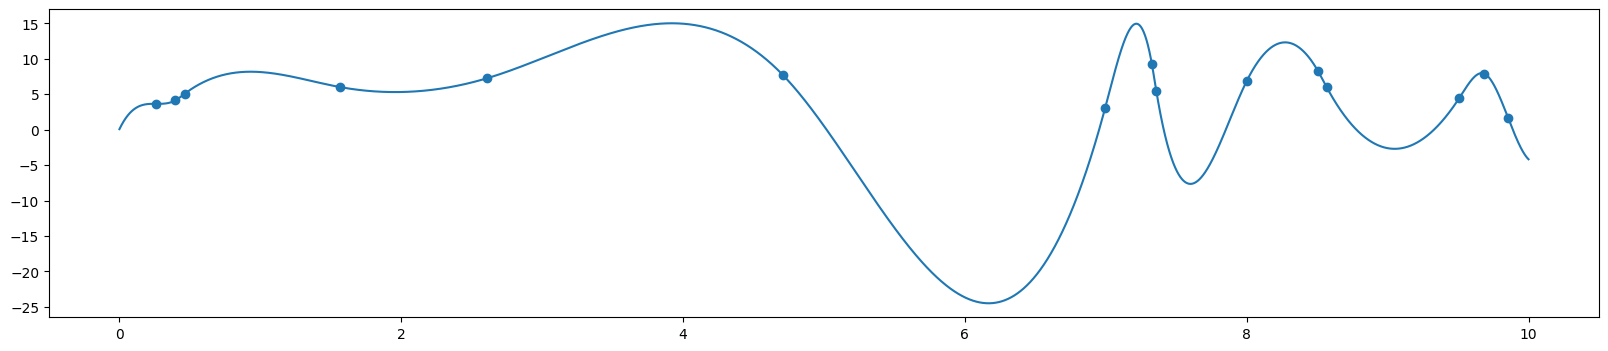

In [ ]:
from scipy.interpolate import CubicSpline
#x = np.array([1.0, 2, 3, 4, 5])
#y = np.array([0.0, 1, 0, 1, 0])
x = np.sort(np.random.uniform(0, 10, 15))
#x = np.random.uniform(0, 10, 15)
y = np.random.uniform(0, 10, 15)

#x_new = np.linspace(0, 6, 10000)
x_new = np.linspace(0, 10, 10000)

k = curvatures(x, y)
#print(k)
y_new = x_new.copy()
for j in range(len(x_new)):
  y_new[j] = evalSpline(x, y, k, x_new[j])

#cs = CubicSpline(x, y, bc_type = "natural")
#y_scipy = cs(x_new)

plt.figure(figsize = (20, 4))
plt.scatter(x, y)
plt.plot(x_new, y_new)
#plt.plot(x_new, y_scipy, color = "red")
#plt.ylim((-10, 20))
plt.show()

***

## Summary

In this notebook we introduced cubic spline interpolants as possibly better *global interpolants* than polynomial interpolants. What is meant by "better global interpolant" can be seen from our original set of toy observations with the polynomial and cubic spline interpolant near the beginning of this notebook. The polynomial interpolant seems to fit the interior observations and the intervals between them in a reasonable manner. The performance of the polynomial interpolant along the left-most and right-most intervals should seem suspect, however -- the interpolant's range along those intervals is very wide and potentially unsupportedly so. The cubic spline interpolant, however, doesn't exhibit this behavior. For this reason, cubic spline interpolants are often preferred over polynomial interpolants.